# Exploratory Analysis

In [11]:
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")


## Loading data

In [2]:
lter = pl.read_csv("./../data/penguins_lter.csv",try_parse_dates=True)
size = pl.read_csv("./../data/penguins_size.csv",try_parse_dates=True)

In [3]:
print("Raw dataset shape:", lter.shape)
print("Cleaned dataset shape:", size.shape)

Raw dataset shape: (344, 17)
Cleaned dataset shape: (344, 7)


In [4]:
print(lter.columns)

['studyName', 'Sample Number', 'Species', 'Region', 'Island', 'Stage', 'Individual ID', 'Clutch Completion', 'Date Egg', 'Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Comments']


In [5]:

# --- (a) Parse Date Egg into datetime, keep month-year ---
lter = lter.with_columns(
    pl.col("Date Egg").str.strptime(pl.Date, "%m/%d/%y", strict=False).alias("egg_date")
)

lter = lter.with_columns([
    pl.col("egg_date").dt.strftime("%b-%Y").alias("Date egg"),   # e.g., Nov-2007
    pl.col("egg_date").dt.year().alias("year")                  # numeric year (for merge later)
])

# --- (b) Convert studyName → Study years (e.g., PAL0708 → 2007-08) ---
lter = lter.with_columns(
    pl.when(pl.col("studyName").str.contains(r"^PAL\d{4}$"))
    .then(
        pl.concat_str([
            (2000 + pl.col("studyName").str.slice(3, 2).cast(pl.Int64)).cast(pl.Utf8),
            pl.lit("-"),
            pl.col("studyName").str.slice(5, 2)
        ])
    )
    .otherwise(None)
    .alias("Study years")
)

# --- (c) Rename columns to final schema ---
lter = lter.rename({
    "Species": "species",
    "Region": "Region",
    "Island": "Island",
    "Clutch Completion": "Clutch Completion",
    "Culmen Length (mm)": "culmen length",
    "Culmen Depth (mm)": "culmen depth",
    "Flipper Length (mm)": "flipper length",
    "Body Mass (g)": "body mass",
    "Sex": "sex",
    "Delta 15 N (o/oo)": "Delta 15 N",
    "Delta 13 C (o/oo)": "Delta 13",
    "Comments": "comments"
})

# --- (d) Standardize species names ---
lter = lter.with_columns(
    pl.when(pl.col("species").str.to_lowercase().str.contains("adelie"))
      .then(pl.lit("Adelie"))
    .when(pl.col("species").str.to_lowercase().str.contains("chinstrap"))
      .then(pl.lit("Chinstrap"))
    .when(pl.col("species").str.to_lowercase().str.contains("gentoo"))
      .then(pl.lit("Gentoo"))
    .otherwise(pl.col("species"))
    .alias("species")
)

# --- (e) Standardize sex values ---
lter = lter.with_columns(
    pl.when(pl.col("sex").str.contains(r"(?i)^male$"))
      .then(pl.lit("Male"))
    .when(pl.col("sex").str.contains(r"(?i)^female$"))
      .then(pl.lit("Female"))
    .otherwise(pl.lit(None))
    .alias("sex")
)

# --- (f) Cast morphometric values as numeric ---
for col in ["culmen length", "culmen depth", "flipper length", "body mass",
            "Delta 15 N", "Delta 13"]:
    lter = lter.with_columns(pl.col(col).cast(pl.Float64, strict=False))

# --- (g) Select only the requested columns ---
lter_clean = lter.select([
    "Study years", "species", "Region", "Island", "Clutch Completion",
    "Date egg", "culmen length", "culmen depth", "flipper length",
    "body mass", "sex", "Delta 15 N", "Delta 13", "comments", "year"   # keep numeric year for merge
])

print(lter_clean.head(10))


shape: (10, 15)
┌─────────────┬─────────┬────────┬───────────┬───┬────────────┬───────────┬─────────────────┬──────┐
│ Study years ┆ species ┆ Region ┆ Island    ┆ … ┆ Delta 15 N ┆ Delta 13  ┆ comments        ┆ year │
│ ---         ┆ ---     ┆ ---    ┆ ---       ┆   ┆ ---        ┆ ---       ┆ ---             ┆ ---  │
│ str         ┆ str     ┆ str    ┆ str       ┆   ┆ f64        ┆ f64       ┆ str             ┆ i32  │
╞═════════════╪═════════╪════════╪═══════════╪═══╪════════════╪═══════════╪═════════════════╪══════╡
│ 2007-08     ┆ Adelie  ┆ Anvers ┆ Torgersen ┆ … ┆ null       ┆ null      ┆ Not enough      ┆ 2007 │
│             ┆         ┆        ┆           ┆   ┆            ┆           ┆ blood for       ┆      │
│             ┆         ┆        ┆           ┆   ┆            ┆           ┆ isotopes.       ┆      │
│ 2007-08     ┆ Adelie  ┆ Anvers ┆ Torgersen ┆ … ┆ 8.94956    ┆ -24.69454 ┆ null            ┆ 2007 │
│ 2007-08     ┆ Adelie  ┆ Anvers ┆ Torgersen ┆ … ┆ 8.36821    ┆ -25.33302 ┆

In [6]:
df = lter_clean.clone()

for col in df.columns:
    if df.schema[col] == pl.Float64:
        # Median and std
        median_val = df.select(pl.col(col).median()).item()
        std_val = df.select(pl.col(col).std()).item()

        if median_val is None or std_val is None:
            continue

        lower, upper = median_val - std_val, median_val + std_val

        # Get mask of nulls
        mask = df.select(pl.col(col).is_null()).to_series().to_numpy()

        if mask.sum() > 0:  # only if nulls exist
            # Generate random values for those nulls
            random_fill = np.random.uniform(lower, upper, mask.sum())

            # Convert column to numpy, replace nulls manually
            col_vals = df[col].to_numpy()
            col_vals[mask] = random_fill

            # Put back into df
            df = df.with_columns(pl.Series(name=col, values=col_vals))

print(df.head(10))


shape: (10, 15)
┌─────────────┬─────────┬────────┬───────────┬───┬────────────┬────────────┬────────────────┬──────┐
│ Study years ┆ species ┆ Region ┆ Island    ┆ … ┆ Delta 15 N ┆ Delta 13   ┆ comments       ┆ year │
│ ---         ┆ ---     ┆ ---    ┆ ---       ┆   ┆ ---        ┆ ---        ┆ ---            ┆ ---  │
│ str         ┆ str     ┆ str    ┆ str       ┆   ┆ f64        ┆ f64        ┆ str            ┆ i32  │
╞═════════════╪═════════╪════════╪═══════════╪═══╪════════════╪════════════╪════════════════╪══════╡
│ 2007-08     ┆ Adelie  ┆ Anvers ┆ Torgersen ┆ … ┆ 9.008799   ┆ -25.707882 ┆ Not enough     ┆ 2007 │
│             ┆         ┆        ┆           ┆   ┆            ┆            ┆ blood for      ┆      │
│             ┆         ┆        ┆           ┆   ┆            ┆            ┆ isotopes.      ┆      │
│ 2007-08     ┆ Adelie  ┆ Anvers ┆ Torgersen ┆ … ┆ 8.94956    ┆ -24.69454  ┆ null           ┆ 2007 │
│ 2007-08     ┆ Adelie  ┆ Anvers ┆ Torgersen ┆ … ┆ 8.36821    ┆ -25.33302  

In [7]:
null_counts = lter_clean.select([
    pl.col(c).null_count().alias(c) for c in lter_clean.columns
])
print(null_counts)


shape: (1, 15)
┌─────────────┬─────────┬────────┬────────┬───┬────────────┬──────────┬──────────┬──────┐
│ Study years ┆ species ┆ Region ┆ Island ┆ … ┆ Delta 15 N ┆ Delta 13 ┆ comments ┆ year │
│ ---         ┆ ---     ┆ ---    ┆ ---    ┆   ┆ ---        ┆ ---      ┆ ---      ┆ ---  │
│ u32         ┆ u32     ┆ u32    ┆ u32    ┆   ┆ u32        ┆ u32      ┆ u32      ┆ u32  │
╞═════════════╪═════════╪════════╪════════╪═══╪════════════╪══════════╪══════════╪══════╡
│ 0           ┆ 0       ┆ 0      ┆ 0      ┆ … ┆ 14         ┆ 13       ┆ 318      ┆ 0    │
└─────────────┴─────────┴────────┴────────┴───┴────────────┴──────────┴──────────┴──────┘


In [8]:
print(df.null_count())

shape: (1, 15)
┌─────────────┬─────────┬────────┬────────┬───┬────────────┬──────────┬──────────┬──────┐
│ Study years ┆ species ┆ Region ┆ Island ┆ … ┆ Delta 15 N ┆ Delta 13 ┆ comments ┆ year │
│ ---         ┆ ---     ┆ ---    ┆ ---    ┆   ┆ ---        ┆ ---      ┆ ---      ┆ ---  │
│ u32         ┆ u32     ┆ u32    ┆ u32    ┆   ┆ u32        ┆ u32      ┆ u32      ┆ u32  │
╞═════════════╪═════════╪════════╪════════╪═══╪════════════╪══════════╪══════════╪══════╡
│ 0           ┆ 0       ┆ 0      ┆ 0      ┆ … ┆ 0          ┆ 0        ┆ 318      ┆ 0    │
└─────────────┴─────────┴────────┴────────┴───┴────────────┴──────────┴──────────┴──────┘


## Visualizations

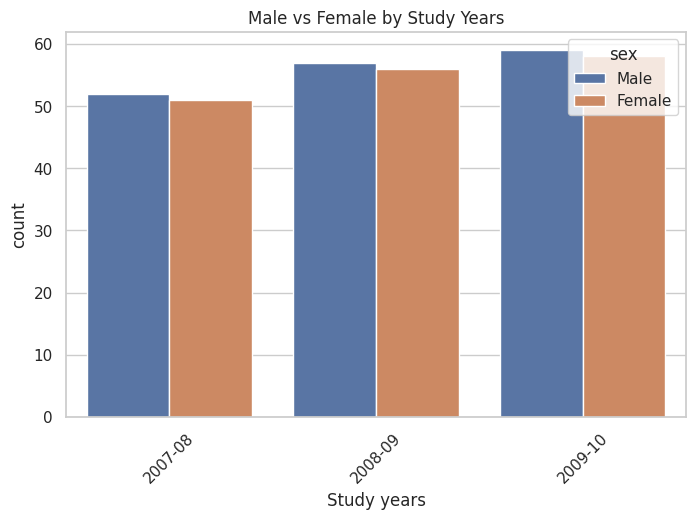

In [13]:
sns.countplot(data=df.to_pandas(), x="Study years", hue="sex")
plt.title("Male vs Female by Study Years")
plt.xticks(rotation=45)
plt.show()

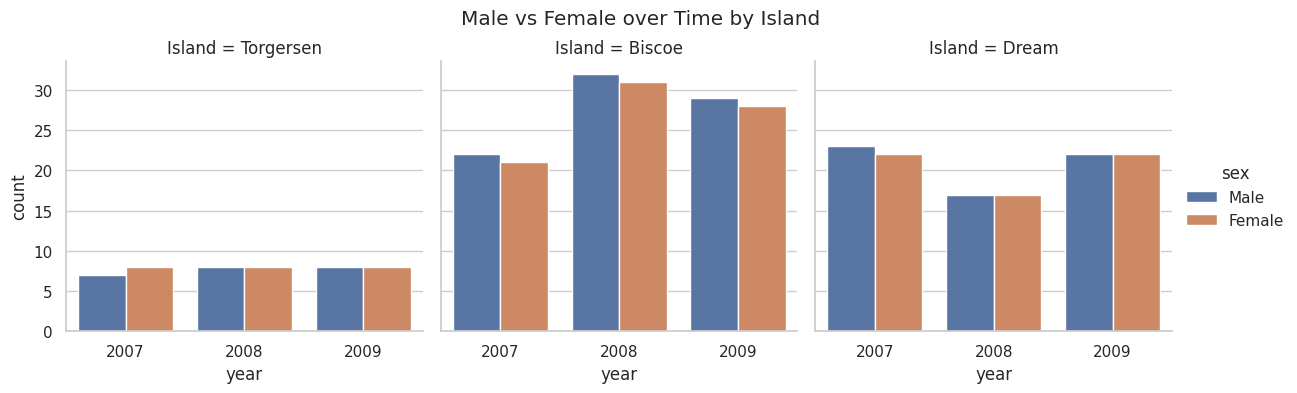

In [14]:
sns.catplot(
    data=df.to_pandas(),
    x="year", hue="sex", col="Island",
    kind="count", col_wrap=3, height=4
)
plt.subplots_adjust(top=0.85)
plt.suptitle("Male vs Female over Time by Island")
plt.show()


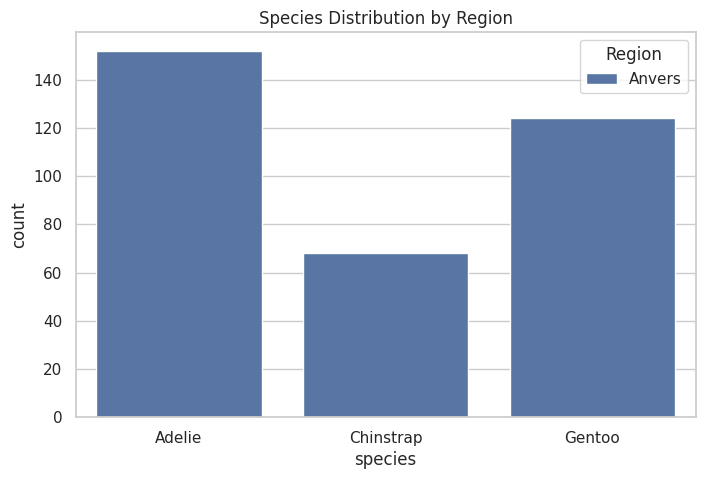

In [17]:
sns.countplot(data=df.to_pandas(), x="species", hue="Region")
plt.title("Species Distribution by Region")
plt.show()

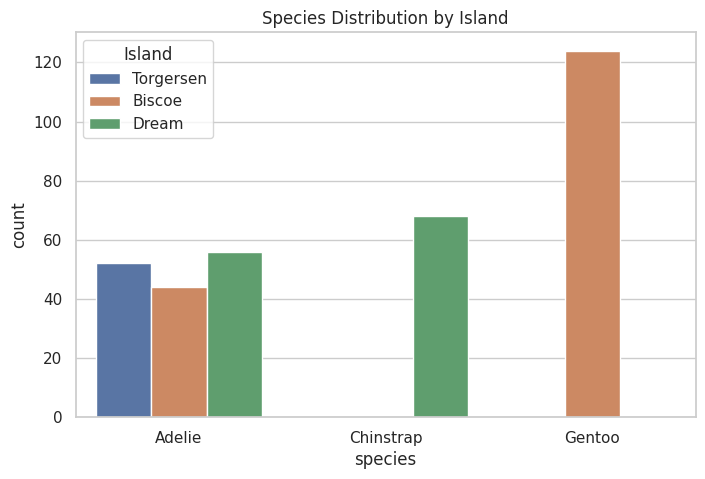

In [18]:
sns.countplot(data=df.to_pandas(), x="species", hue="Island")
plt.title("Species Distribution by Island")
plt.show()

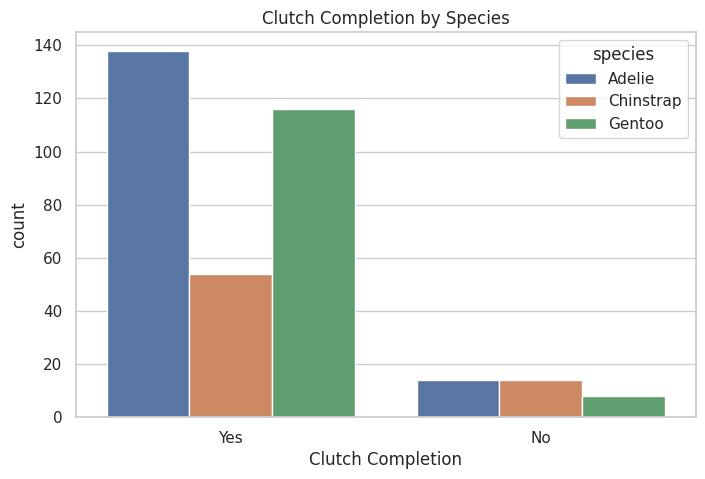

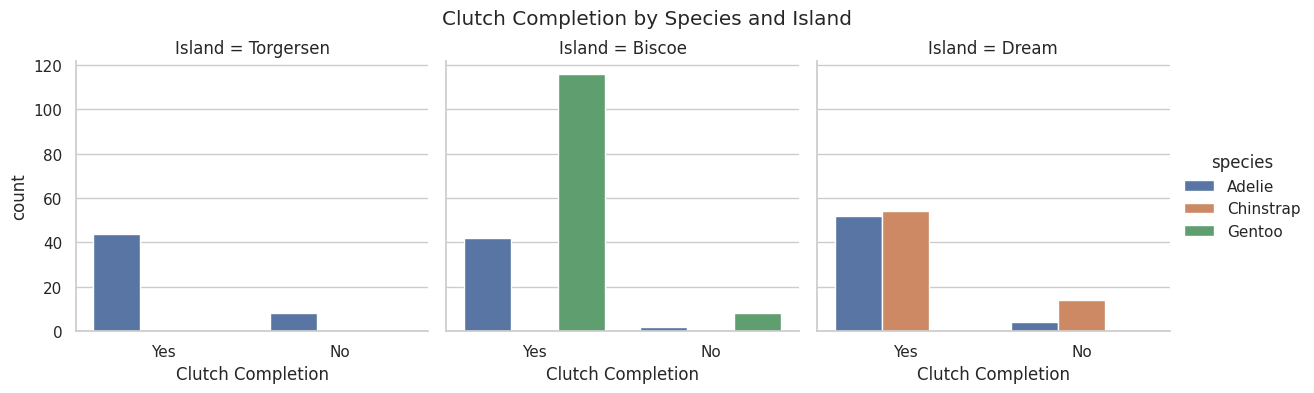

In [19]:
sns.countplot(data=df.to_pandas(), x="Clutch Completion", hue="species")
plt.title("Clutch Completion by Species")
plt.show()

sns.catplot(
    data=df.to_pandas(),
    x="Clutch Completion", hue="species", col="Island",
    kind="count", col_wrap=3, height=4
)
plt.subplots_adjust(top=0.85)
plt.suptitle("Clutch Completion by Species and Island")
plt.show()


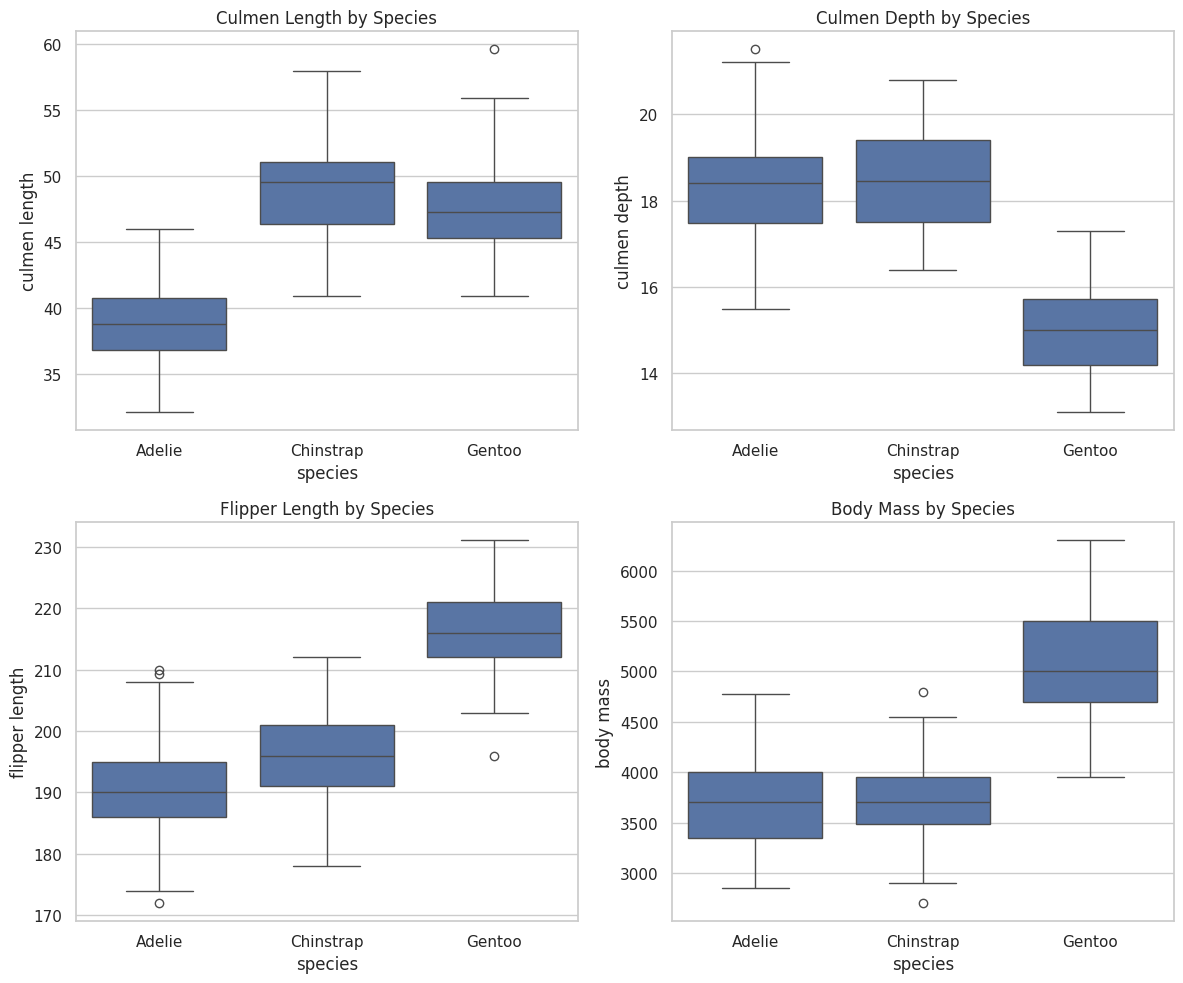

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.boxplot(data=df.to_pandas(), x="species", y="culmen length", ax=axes[0,0])
axes[0,0].set_title("Culmen Length by Species")

sns.boxplot(data=df.to_pandas(), x="species", y="culmen depth", ax=axes[0,1])
axes[0,1].set_title("Culmen Depth by Species")

sns.boxplot(data=df.to_pandas(), x="species", y="flipper length", ax=axes[1,0])
axes[1,0].set_title("Flipper Length by Species")

sns.boxplot(data=df.to_pandas(), x="species", y="body mass", ax=axes[1,1])
axes[1,1].set_title("Body Mass by Species")

plt.tight_layout()
plt.show()


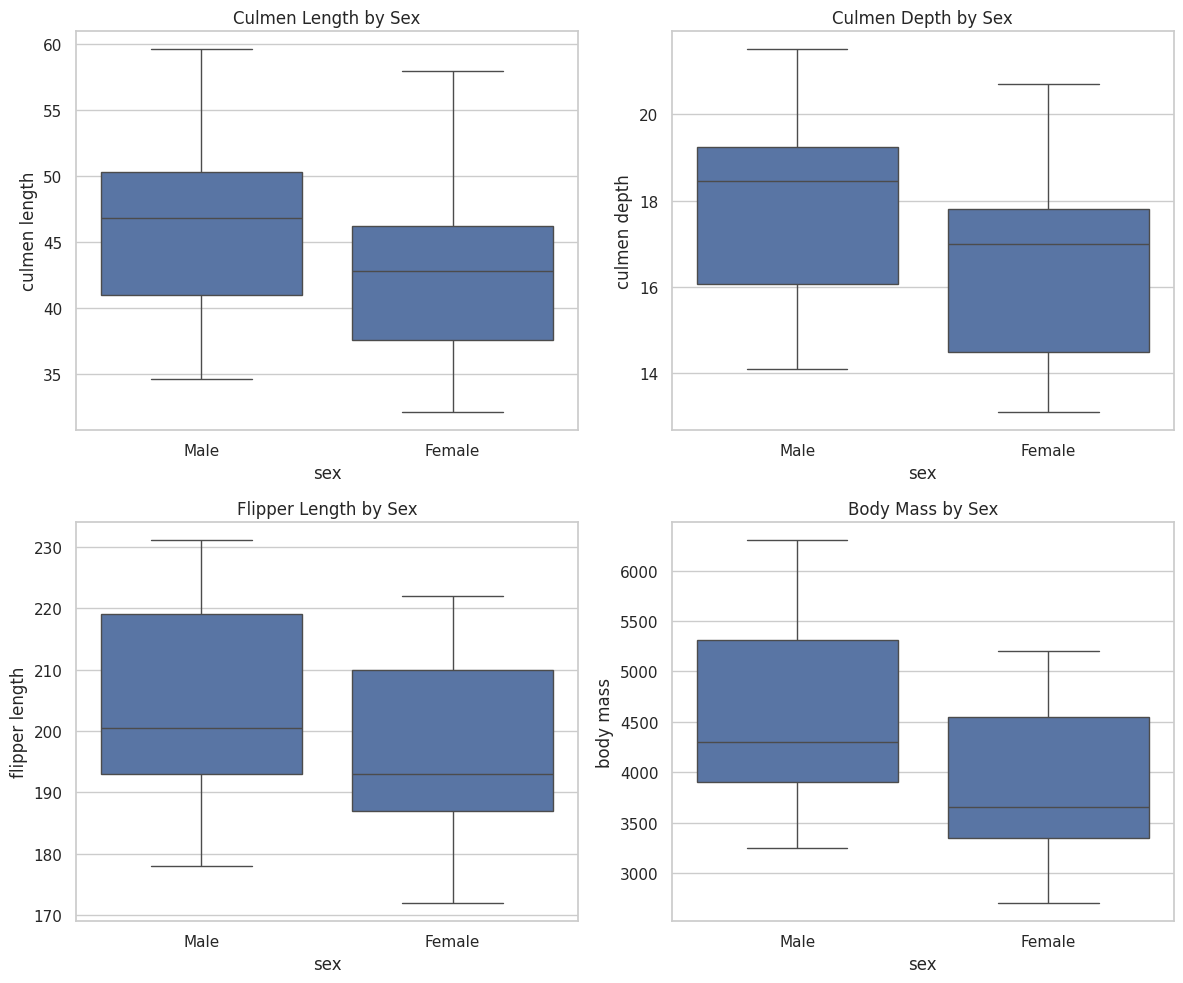

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.boxplot(data=df.to_pandas(), x="sex", y="culmen length", ax=axes[0,0])
axes[0,0].set_title("Culmen Length by Sex")

sns.boxplot(data=df.to_pandas(), x="sex", y="culmen depth", ax=axes[0,1])
axes[0,1].set_title("Culmen Depth by Sex")

sns.boxplot(data=df.to_pandas(), x="sex", y="flipper length", ax=axes[1,0])
axes[1,0].set_title("Flipper Length by Sex")

sns.boxplot(data=df.to_pandas(), x="sex", y="body mass", ax=axes[1,1])
axes[1,1].set_title("Body Mass by Sex")

plt.tight_layout()
plt.show()


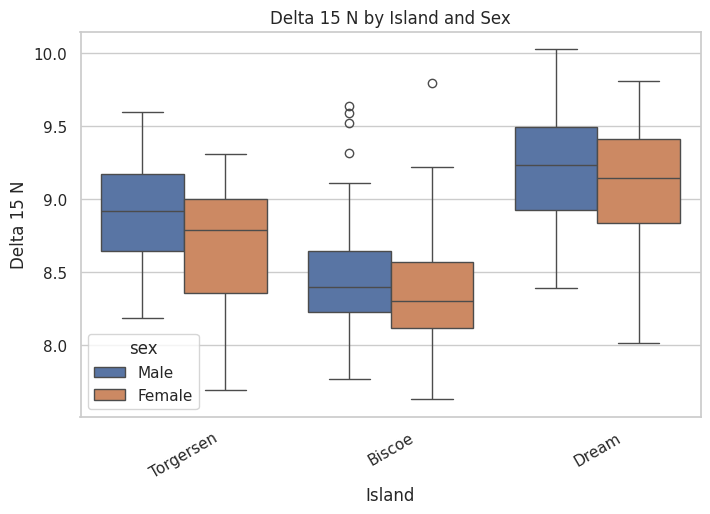

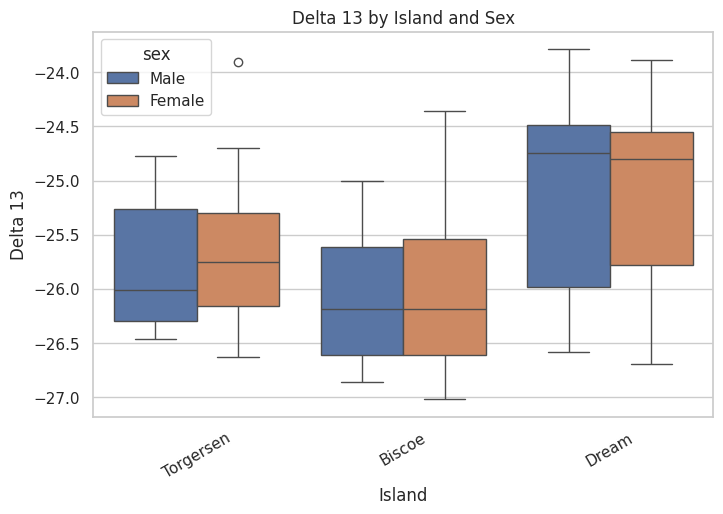

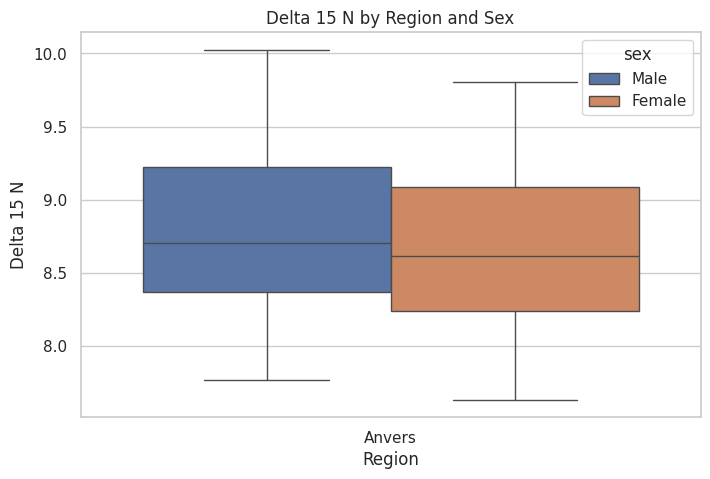

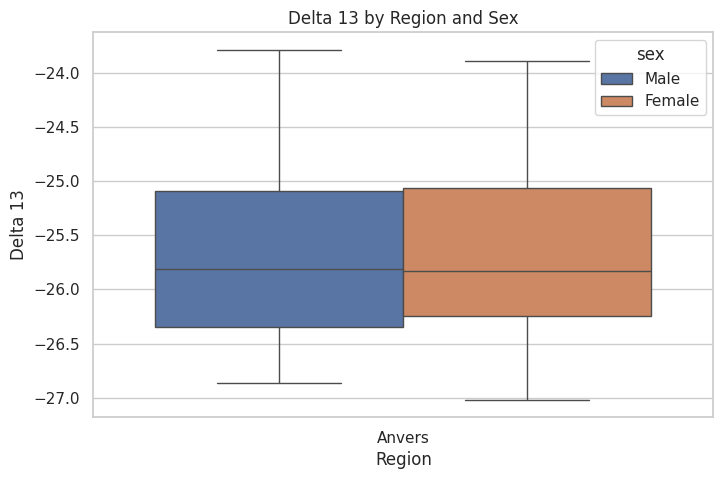

In [22]:
sns.boxplot(data=df.to_pandas(), x="Island", y="Delta 15 N", hue="sex")
plt.title("Delta 15 N by Island and Sex")
plt.xticks(rotation=30)
plt.show()

sns.boxplot(data=df.to_pandas(), x="Island", y="Delta 13", hue="sex")
plt.title("Delta 13 by Island and Sex")
plt.xticks(rotation=30)
plt.show()

sns.boxplot(data=df.to_pandas(), x="Region", y="Delta 15 N", hue="sex")
plt.title("Delta 15 N by Region and Sex")
plt.show()

sns.boxplot(data=df.to_pandas(), x="Region", y="Delta 13", hue="sex")
plt.title("Delta 13 by Region and Sex")
plt.show()


1. combine the 2 datasets
2. study years | species | Region | Island | Clutch Completion | Date egg | culmen length | culmen depth | flipper length | body mass | sex | Delta 15 N | Delta 13 | comments

1. maale female ocunt accorind to study years
2. male female over time for different islands
3. species distribution for different regions and islands
4. cluthc completion based on region and islands and species
5. culmen length for different species
6. culmen depth for diffeent species
7. flipper length for different species
8. body mass for different species
9. same 4 metrics based on sex
10. same 4 metrics based on
11. delta 15 n and 13 levels based on region and islands and genders

